In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3
from matplotlib import pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from sklearn.utils import resample
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances as distance
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import ward, dendrogram, linkage
from sklearn.decomposition import PCA

In [2]:
names = np.array(["Theresa_May.txt","Tony_Blair.txt","Gordon_Brown.txt","Alec_Douglas.txt","David_Cameron.txt"
                  ,"Edward_Heath.txt","Harold_Wilson.txt","James_Callaghan.txt","John_Major.txt",
                  "Margaret_Thatcher.txt","Harold_Macmillan.txt","Anthony_Eden.txt","Winston_Churchill.txt"]) 
summary = []

for name in names:
    #print(name)
    f = open("Text_Files//"+name,encoding="utf8")
    summary.append(f.read())
    

In [3]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


stemmed_list = []
tokenized_list = []
for i in summary:
    
    allwords_stemmed = tokenize_and_stem(i)
    stemmed_list.append(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    tokenized_list.append(allwords_tokenized)
    
    

We must now take a bootstrapped version of all the texts of each PM. The bootstrapped versions will then be appended on the the $boot\_all$ list

In [4]:
#Define an empty list that will be appended with all the individual bootstrapped texts
boot_all = []

for i in range(len(summary)):
    
    PM_text = summary[i] 
    temp_token = tokenize_only(PM_text)
    temp_length = len(temp_token)
    temp_boot = resample(temp_token, replace = False, n_samples = int(1*temp_length),random_state = 10)
    boot_all.append(temp_boot)       

Now follow the same procedure as before, but with the bootstrapped samples

In [5]:
vocab_frame = pd.DataFrame({'words': allwords_tokenized}, index = allwords_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')


there are 25670 items in vocab_frame


In [6]:
#calculating the average length:
lengths = [len(x) for x in tokenized_list]
print(np.mean(lengths))

11241.538461538461


In [7]:
#It seems that the argument of tfidf vectorizer transform must be a continuous text instead of a list.
#So we have to remove the commas and separate them with spaces

lista = []

for i in range(len(boot_all)):
    
    temp_list = boot_all[i]
    temp = " ".join(temp_list)
    lista.append(temp)

In [9]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.6, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(lista) #fit the vectorizer to synopses
terms = tfidf_vectorizer.get_feature_names() #apparently this reduces the features??

print(tfidf_matrix.shape)

CPU times: user 3.58 s, sys: 44.6 ms, total: 3.63 s
Wall time: 3.67 s
(13, 607)


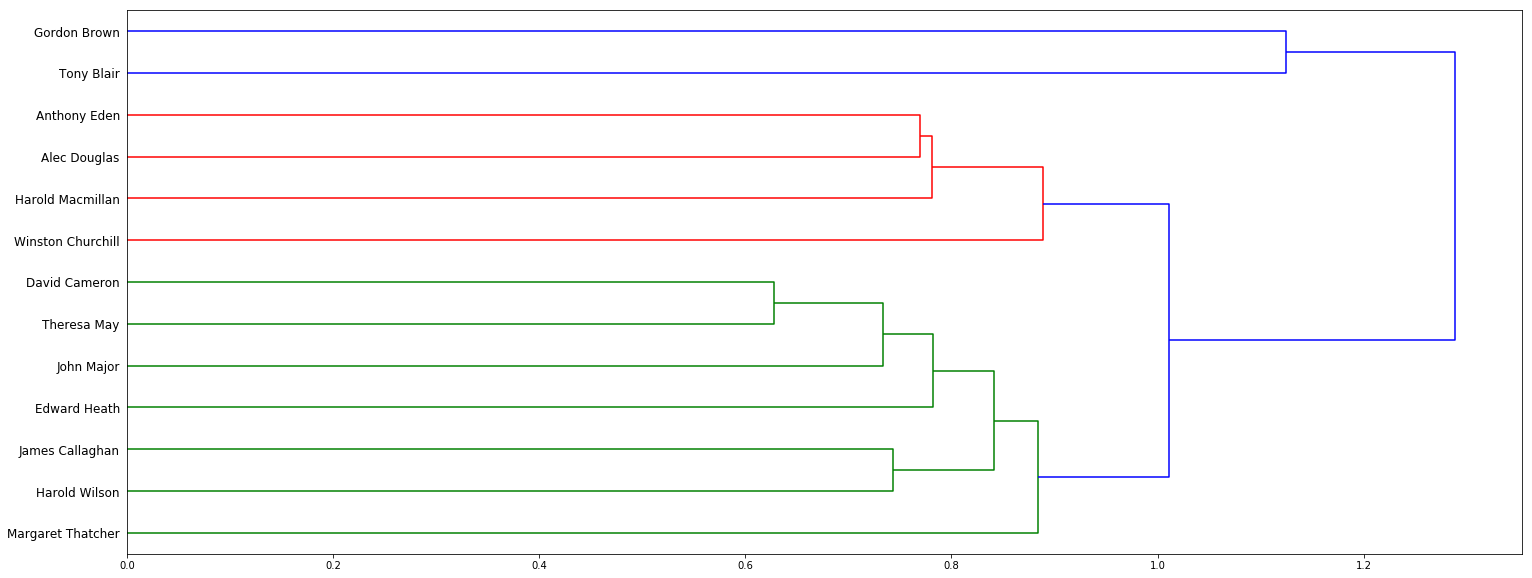

In [37]:
dist = 1 - cosine_similarity(tfidf_matrix)

#linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix = linkage(dist)
#print(linkage_matrix)
titles = list(names)

#fig, ax = plt.subplots(figsize=(15, 20)) # set size
#ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

#plt.tick_params(\
#    axis= 'x',          # changes apply to the x-axis
 #   which='both',      # both major and minor ticks are affected
  #  bottom=False,      # ticks along the bottom edge are off
   # top=False,         # ticks along the top edge are off
    #labelbottom=False)

#plt.tight_layout() #show plot with tight layout
proper_names = ["Theresa May","Tony Blair","Gordon Brown","Alec Douglas","David Cameron","Edward Heath","Harold Wilson",
           "James Callaghan","John Major","Margaret Thatcher","Harold Macmillan","Anthony Eden","Winston Churchill"]
#uncomment below to save figure

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_matrix, labels = proper_names, orientation = "right")

#plt.savefig('Figures\\Traditional_Politicians\\Politicians_Dendrogram_No_Bootstrap.pdf') #save figure as ward_clusters


In [ ]:
#linkage_matrix = linkage(dist2) #define the linkage_matrix using ward clustering pre-computed distances
#titles = list(names)

#fig = plt.figure(figsize=(25, 10))
#dn = dendrogram(linkage_matrix, labels = titles)
#plt.savefig('ward_clusters_euclidean.pdf') #save figure as ward_clusters

## K-Means method on Politicians

Wall time: 20.8 ms
[2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0]


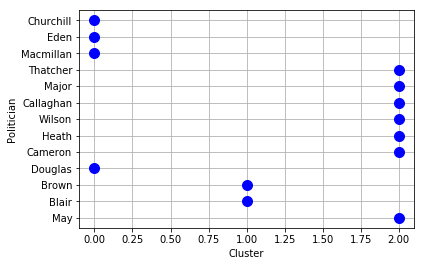

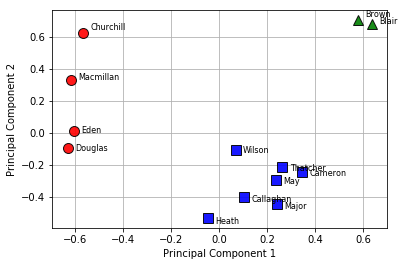

In [36]:
from sklearn.cluster import KMeans

num_clusters = 3     #Set the number of clusters
km = KMeans(n_clusters=num_clusters)

%time km.fit(dist)     #Fit K-Means using the distance matrix

clusters = km.labels_.tolist()
print (clusters)

plt.plot(clusters,proper_names, 'o', color = 'blue', markersize = 10)
plt.grid()
plt.xlabel("Cluster")
plt.ylabel("Politician")
#plt.savefig("KMeansClustering.pdf")
colours = ["red","green","blue","purple"]
#colours = [(0.2,0.5,0.2),(0.2,0.5,0.5),(0.2,0.5,0.9)]

shape = ["o", "^", "s", "X"]

#plt.savefig("Figures\\LDA_BBC\\politicians_k_means_boostrap_seed_"+str(seed)+".pdf")

#try to perform a PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

coordinates = pca.fit_transform(dist)
#print(coordinates)
#print(np.sum(np.abs(coordinates),axis = 0))

proper_names = ["May","Blair","Brown","Douglas","Cameron","Heath","Wilson",
           "Callaghan","Major","Thatcher","Macmillan","Eden","Churchill"]


plt.figure()#figsize = (8,6)
for i, txt in enumerate(names):
    
    if i == 1:
        plt.plot(coordinates[i,0], coordinates[i,1],marker = shape[clusters[i]],color = colours[clusters[i]],
             markersize = 10,alpha = 0.9,markeredgecolor = "black", label = proper_names[i])
        plt.text(coordinates[i,0]+0.03, coordinates[i,1],s = proper_names[i],size=8
             ,bbox=dict(boxstyle="square",
                   ec=(1., 1.0, 1.0),
                   fc=(1., 1, 1),alpha = 0))
        
    else:
        plt.plot(coordinates[i,0], coordinates[i,1],marker = shape[clusters[i]],color = colours[clusters[i]],
             markersize = 10,alpha = 0.9,markeredgecolor = "black", label = proper_names[i])
        plt.text(coordinates[i,0]+0.03, coordinates[i,1]*(1.05)-0.01,s = proper_names[i],size=8
                 ,bbox=dict(boxstyle="square",
                   ec=(1., 1.0, 1.0),
                   fc=(1., 1, 1),alpha = 0))
    
#plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.grid()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
#plt.savefig("Figures\\LDA_BBC\\politicians_PCA_boostrap_seed_"+str(seed)+".pdf")
#plt.savefig("Figures\\Traditional_Politicians\\Politicians_PCA_No_Bootstrap.pdf")
#np.savetxt("Figures\\LDA_BBC\\c_list.txt",c_list)

We have produced 2 graphs for the 2 original methods: $$ 1 - Hierarchical Clustering $$  $$ 2 - K-Means (with PCA) $$ 

We can see that the two methods seem to aegree between them in terms of the clusters that they produce. 

Now let's implement bootstrapping and produce more graphs for these two methods. 

In [49]:
pplist =[]

In [85]:
#Bootstrapping on Hierarchical Clustering 

#Define an empty list that will be appended with all the individual bootstrapped texts
boot_all = []
seed = 1

for i in range(len(summary)):
    
    PM_text = summary[i] 
    temp_token = tokenize_only(PM_text)
    temp_length = len(temp_token)
    temp_boot = resample(temp_token, replace = True, n_samples = int(1*temp_length),random_state = seed)
    boot_all.append(temp_boot)  
    
    
vocab_frame = pd.DataFrame({'words': allwords_tokenized}, index = allwords_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

#It seems that the argument of tfidf vectorizer transform must be a continuous text instead of a list.
#So we have to remove the commas and separate them with spaces

lista = []

for i in range(len(boot_all)):
    
    temp_list = boot_all[i]
    temp = " ".join(temp_list)
    lista.append(temp)
    

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.6, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(lista) #fit the vectorizer to synopses
terms = tfidf_vectorizer.get_feature_names() #apparently this reduces the features??

#print(tfidf_matrix.shape)


there are 25670 items in vocab_frame
Wall time: 6.4 s


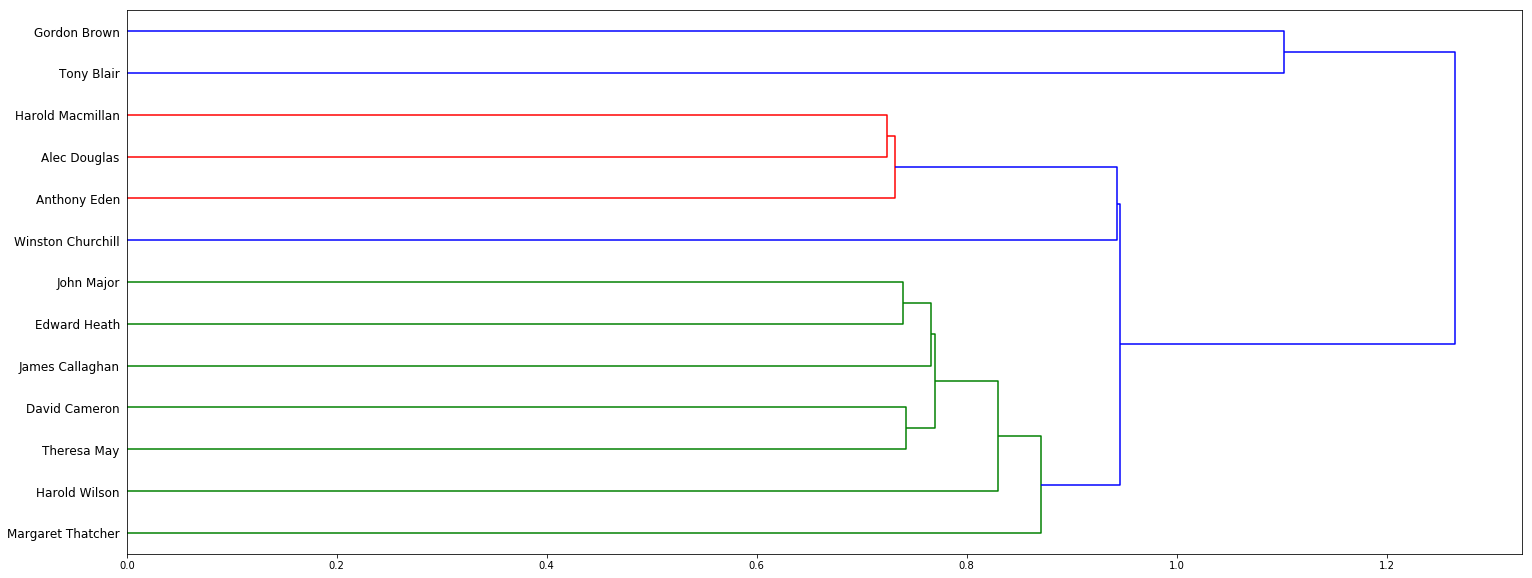

In [86]:
dist = 1 - cosine_similarity(tfidf_matrix)

#linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix = linkage(dist)
#print(linkage_matrix)
titles = list(names)

#fig, ax = plt.subplots(figsize=(15, 20)) # set size
#ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

#plt.tick_params(\
#    axis= 'x',          # changes apply to the x-axis
 #   which='both',      # both major and minor ticks are affected
  #  bottom=False,      # ticks along the bottom edge are off
   # top=False,         # ticks along the top edge are off
    #labelbottom=False)

#plt.tight_layout() #show plot with tight layout
proper_names = ["Theresa May","Tony Blair","Gordon Brown","Alec Douglas","David Cameron","Edward Heath","Harold Wilson",
           "James Callaghan","John Major","Margaret Thatcher","Harold Macmillan","Anthony Eden","Winston Churchill"]
#uncomment below to save figure

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_matrix, labels = proper_names, orientation = "right")

#plt.savefig('Figures\\Traditional_Politicians\\Politicians_Dendrogram_Bootstrap_Seed_' + str(seed) + '.pdf') #save figure as ward_clusters


Wall time: 53.1 ms
[0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]


Text(0,0.5,'Principal Component 2')

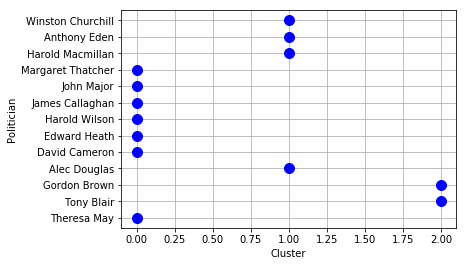

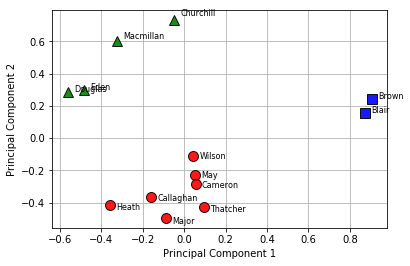

In [87]:
## from sklearn.cluster import KMeans

num_clusters = 3     #Set the number of clusters
km = KMeans(n_clusters=num_clusters)

%time km.fit(dist)     #Fit K-Means using the distance matrix

clusters = km.labels_.tolist()
print (clusters)
pplist.append(clusters)

plt.plot(clusters,proper_names, 'o', color = 'blue', markersize = 10)
plt.grid()
plt.xlabel("Cluster")
plt.ylabel("Politician")
#plt.savefig("KMeansClustering.pdf")
colours = ["red","green","blue","purple"]
#colours = [(0.2,0.5,0.2),(0.2,0.5,0.5),(0.2,0.5,0.9)]

shape = ["o", "^", "s", "X"]

#plt.savefig("Figures\\LDA_BBC\\politicians_k_means_boostrap_seed_"+str(seed)+".pdf")

#try to perform a PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=4)

coordinates = pca.fit_transform(dist)
#print(coordinates)
#print(np.sum(np.abs(coordinates),axis = 0))

proper_names = ["May","Blair","Brown","Douglas","Cameron","Heath","Wilson",
           "Callaghan","Major","Thatcher","Macmillan","Eden","Churchill"]


plt.figure()#figsize = (8,6)
for i, txt in enumerate(names):
    
    if i == 1:
        plt.plot(coordinates[i,0], coordinates[i,1],marker = shape[clusters[i]],color = colours[clusters[i]],
             markersize = 10,alpha = 0.9,markeredgecolor = "black", label = proper_names[i])
        plt.text(coordinates[i,0]+0.03, coordinates[i,1],s = proper_names[i],size=8
             ,bbox=dict(boxstyle="square",
                   ec=(1., 1.0, 1.0),
                   fc=(1., 1, 1),alpha = 0))
        
    else:
        plt.plot(coordinates[i,0], coordinates[i,1],marker = shape[clusters[i]],color = colours[clusters[i]],
             markersize = 10,alpha = 0.9,markeredgecolor = "black", label = proper_names[i])
        plt.text(coordinates[i,0]+0.03, coordinates[i,1]*(1.05)-0.01,s = proper_names[i],size=8
                 ,bbox=dict(boxstyle="square",
                   ec=(1., 1.0, 1.0),
                   fc=(1., 1, 1),alpha = 0))
    
#plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.grid()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
#plt.savefig("Figures\\Traditional_Politicians\\Politicians_PCA_Boostrap_Seed_"+str(seed)+".pdf")
#np.savetxt("quality_tou_kinitou_sou.txt",pplist)

By changing the seed, we can produce many graphs. We have produced graphs that range from seed 0,1,2,...,9 and we observe that the clusters are not consistent between them. 

Does this mean that this method is not robust? 

On the other hand, we see that there are clusters. 

[+++ need to check this again]
